# Exemplo de Regressão Logística usando Softmax

Utiliza uma rede neural de uma camada e função Softmax. A programação da rede, assim
como o seu treinamento e predição utilizam programação matricial, sem fazer uso de
bibliotecas de *machine learning*.


### Este tutorial foi inspirado no blog : [Gist Softmax por Arthur Juliani](https://medium.com/@awjuliani/simple-softmax-in-python-tutorial-d6b4c4ed5c16#.98wxaxxsc)

Objetivo deste exemplo é codificar o método de Regressão Logística utilizando Softmax e
gradiente descendente. As bibliotecas usadas são mínimas, principalmente as funções básicas
matriciais dos pacotes `NumPy` e `Scipy`. As demais bibliotecas são usadas neste exemplo apenas para: `pandas` - para imprimir a matriz de confusão; `keras` - para carregar o conjunto de
dados do NMIST; `matplotlib` - para mostrar gráfico e imagens.

In [50]:
import numpy as np
import scipy.sparse

import pandas as pd
import keras
from keras.datasets import mnist 
import matplotlib.pyplot as plt
%matplotlib inline


The below function converts integer class coding, where there is a unidimensional array of labels into a one-hot varient, where the array is size m (examples) x k (classes).

In [109]:
def oneHotIt(Y):
    m = Y.shape[0]
    Y_oh = scipy.sparse.csr_matrix((np.ones(m), (Y, np.array(range(m)))))
    Y_oh = np.array(Y_oh.todense()).T
    return Y_oh

Carregamento dos dados do NMIST, disponível no `Keras`.
Este exemplo utiliza 500 amostras de treinamento e 100 amostras para testes.


In [95]:
# the data, shuffled and split between train and test sets 
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()


Now we set the loaded data as our x and y variables for both the train and test sets.

X.shape: (500, 785)
Y.shape: (500,)
Y_oh.shape: (500, 10)
class: 5


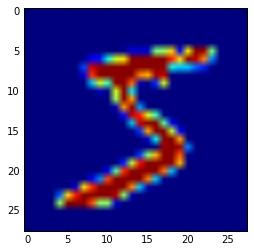

In [114]:
Y = Y_train[:500]
Y_oh = oneHotIt(Y)
X = X_train[:500].reshape((-1,28*28))/255.
X = np.hstack([np.ones((500,1)),X]) # incluído X00 como 1 para gerar bias no W
testY = Y_test[:100]
testX = X_test[:100].reshape((-1,28*28))/255.
testX = np.hstack([np.ones((100,1)),testX]) # incluído X00 como 1 para gerar bias no W

print 'X.shape:', X.shape
print 'Y.shape:', Y.shape
print 'Y_oh.shape:', Y_oh.shape
plt.imshow(np.reshape(X[0,1:],[28,28])) # retirando primeira coluna (bias no W)
print 'class:',Y[0]

![](https://sebastianraschka.com/images/faq/softmax_regression/logistic_regression_schematic.png)

### Before we can get to training our model using the data, we will have to define a few functions that the training and testing process can use.

Função que calcula a transformação `softmax`:
Recebe como entrada uma matriz dos *scores* no formato: linhas é igual número de amostras `n`
e colunas igual ao número de classes `k`.

`Softmax` calcula um exponencial normalizado. 

No resultado, a soma de cada linha referente à amostra `j` é 1, pois cada coluna
representa a probabilidade de ser cada a classe `k`. 

$$ S^{(j)} = \frac{\exp(\boldsymbol{z}^{(j)})}{\sum_{i=0}^{k-1} \exp(z^{(j)}_{i})} $$

![](../figures/softmax_matrizes.png)

In [89]:
def softmax(Z):
    # computes softmax for all samples, normalize among classes (columns)
    # input z: scores; shape: samples rows x classes columns
    # output sm: same shape of input
    EZ = np.exp(Z)
    S = EZ / EZ.sum(axis=1,keepdims=True)
    return S

Here we determine the predictions for each class when given a set of input data:
X: n amostras x m attributes
W: m attributes x k classes
Y_hat: n amostras x k classes

In [90]:
def predict(X,W):
    S = softmax(X.dot(W))
    Y_hat = np.argmax(S,axis=1)
    return Y_hat

### Este é o laço principal da Regressão Logística por Softmax

Os pesos são inicializados em zero, sem fator de regularização.
Em cada iteração, a função a ser minimizada é calculada e os pesos são ajustados
pelo técnica de gradiente descendente.

A função a ser minimizada é a função $J$ de perda, que é baseada na Entropia Cruzada (*Cross Entropy*). Dado um conjunto de **amostras anotadas**, isto é, amostras $\boldsymbol{X}$ com
classe $\boldsymbol{Y}$, encontrar os pesos $\boldsymbol{W}$ que minimizam $J$:

$$ J_{\boldsymbol{X,Y}_{TRUE}}(\boldsymbol{W}) = -\frac{1}{n} \sum \boldsymbol{Y}_{TRUE} \odot \log{\boldsymbol{S}(\boldsymbol{XW})}$$
onde $\odot$ é multiplicação ponto-a-ponto de matrizes.

A minimização é feita através do método de gradiente descendente. O gradiente de $J$ é dado por:

$$ \boldsymbol{\Delta J(W)} = - \frac{1}{n} \boldsymbol{X}^T (\boldsymbol{Y}_{TRUE} - \boldsymbol{S(XW)}) $$ 

Os pesos são então ajustados em cada *batch* pela equação onde $\eta$ é denominado de
taxa de aprendizagem: *learning rate*:

$$ \boldsymbol{W} = \boldsymbol{W} - \eta \boldsymbol{\Delta J(W)} $$ 

A cada iteração no programa de minimização abaixo, os pesos são ajustados aplicando-se o
gradiente descendente utilizando todo o conjunto de treinamento. Este esquema é denominado
de "batch gradient descent".

We can look at how the loss (hopefully) decreases over time.

In [113]:
n = X.shape[0] # number of training examples
m = X.shape[1] # number of attributes (features, pixels + 1(bias))
k = 10         # number of classes
W = np.zeros([m,k]) # n. de linhas é igual a número de atributos (features, pixels)
print 'W.shape:', W.shape
lam = 0 # 1
iterations = 1000
learningRate = 1e-5
losses = []
for i in range(iterations):
    scores = X.dot(W)
    S = softmax(scores)
    loss = (-1 / n) * np.sum(Y_oh * np.log(S)) + (lam/2) * (W*W).sum() 
    Grad = (-1 / n) * (X.T).dot(Y_oh - S) + lam*W 
    W = W - (learningRate * Grad)
    losses.append(loss)
print 'Final loss:',loss
# usual dar loss de 317.25

W.shape: (785, 10)
Final loss: 316.605577525


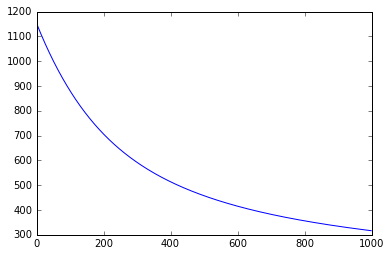

In [105]:
plt.plot(losses)

### Now that we have trained our model, we can see how well it is able to perform on both the training and test sets:

In [67]:
def getAccuracy(X,W, Y):
    Y_hat = predict(X,W)
    accuracy = sum(Y_hat == Y)/(float(len(Y)))
    return accuracy

In [106]:
print 'Training Accuracy: ', getAccuracy(X,W,Y)
print 'Test Accuracy: ', getAccuracy(testX,W,testY)
# usual 0.868 e 0.77

Training Accuracy:  0.87
Test Accuracy:  0.77


### One of the benefits of a simple model like softmax is that we can visualize the weights for each of the classes, and see what it prefers. Here we look at the weights for the '3' class.

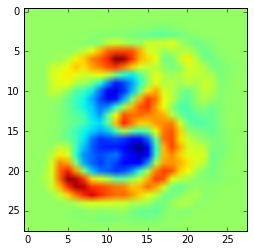

In [108]:
# Visualizando pesos da classe 3
plt.imshow(W[1:,3].reshape((28,28)))